# N:1 MENT-S — marginal projections

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import proplot as pplt
import psdist as ps
import psdist.plot as psv
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.utils import unravel

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
X_true = dist.sample(1_000_000)

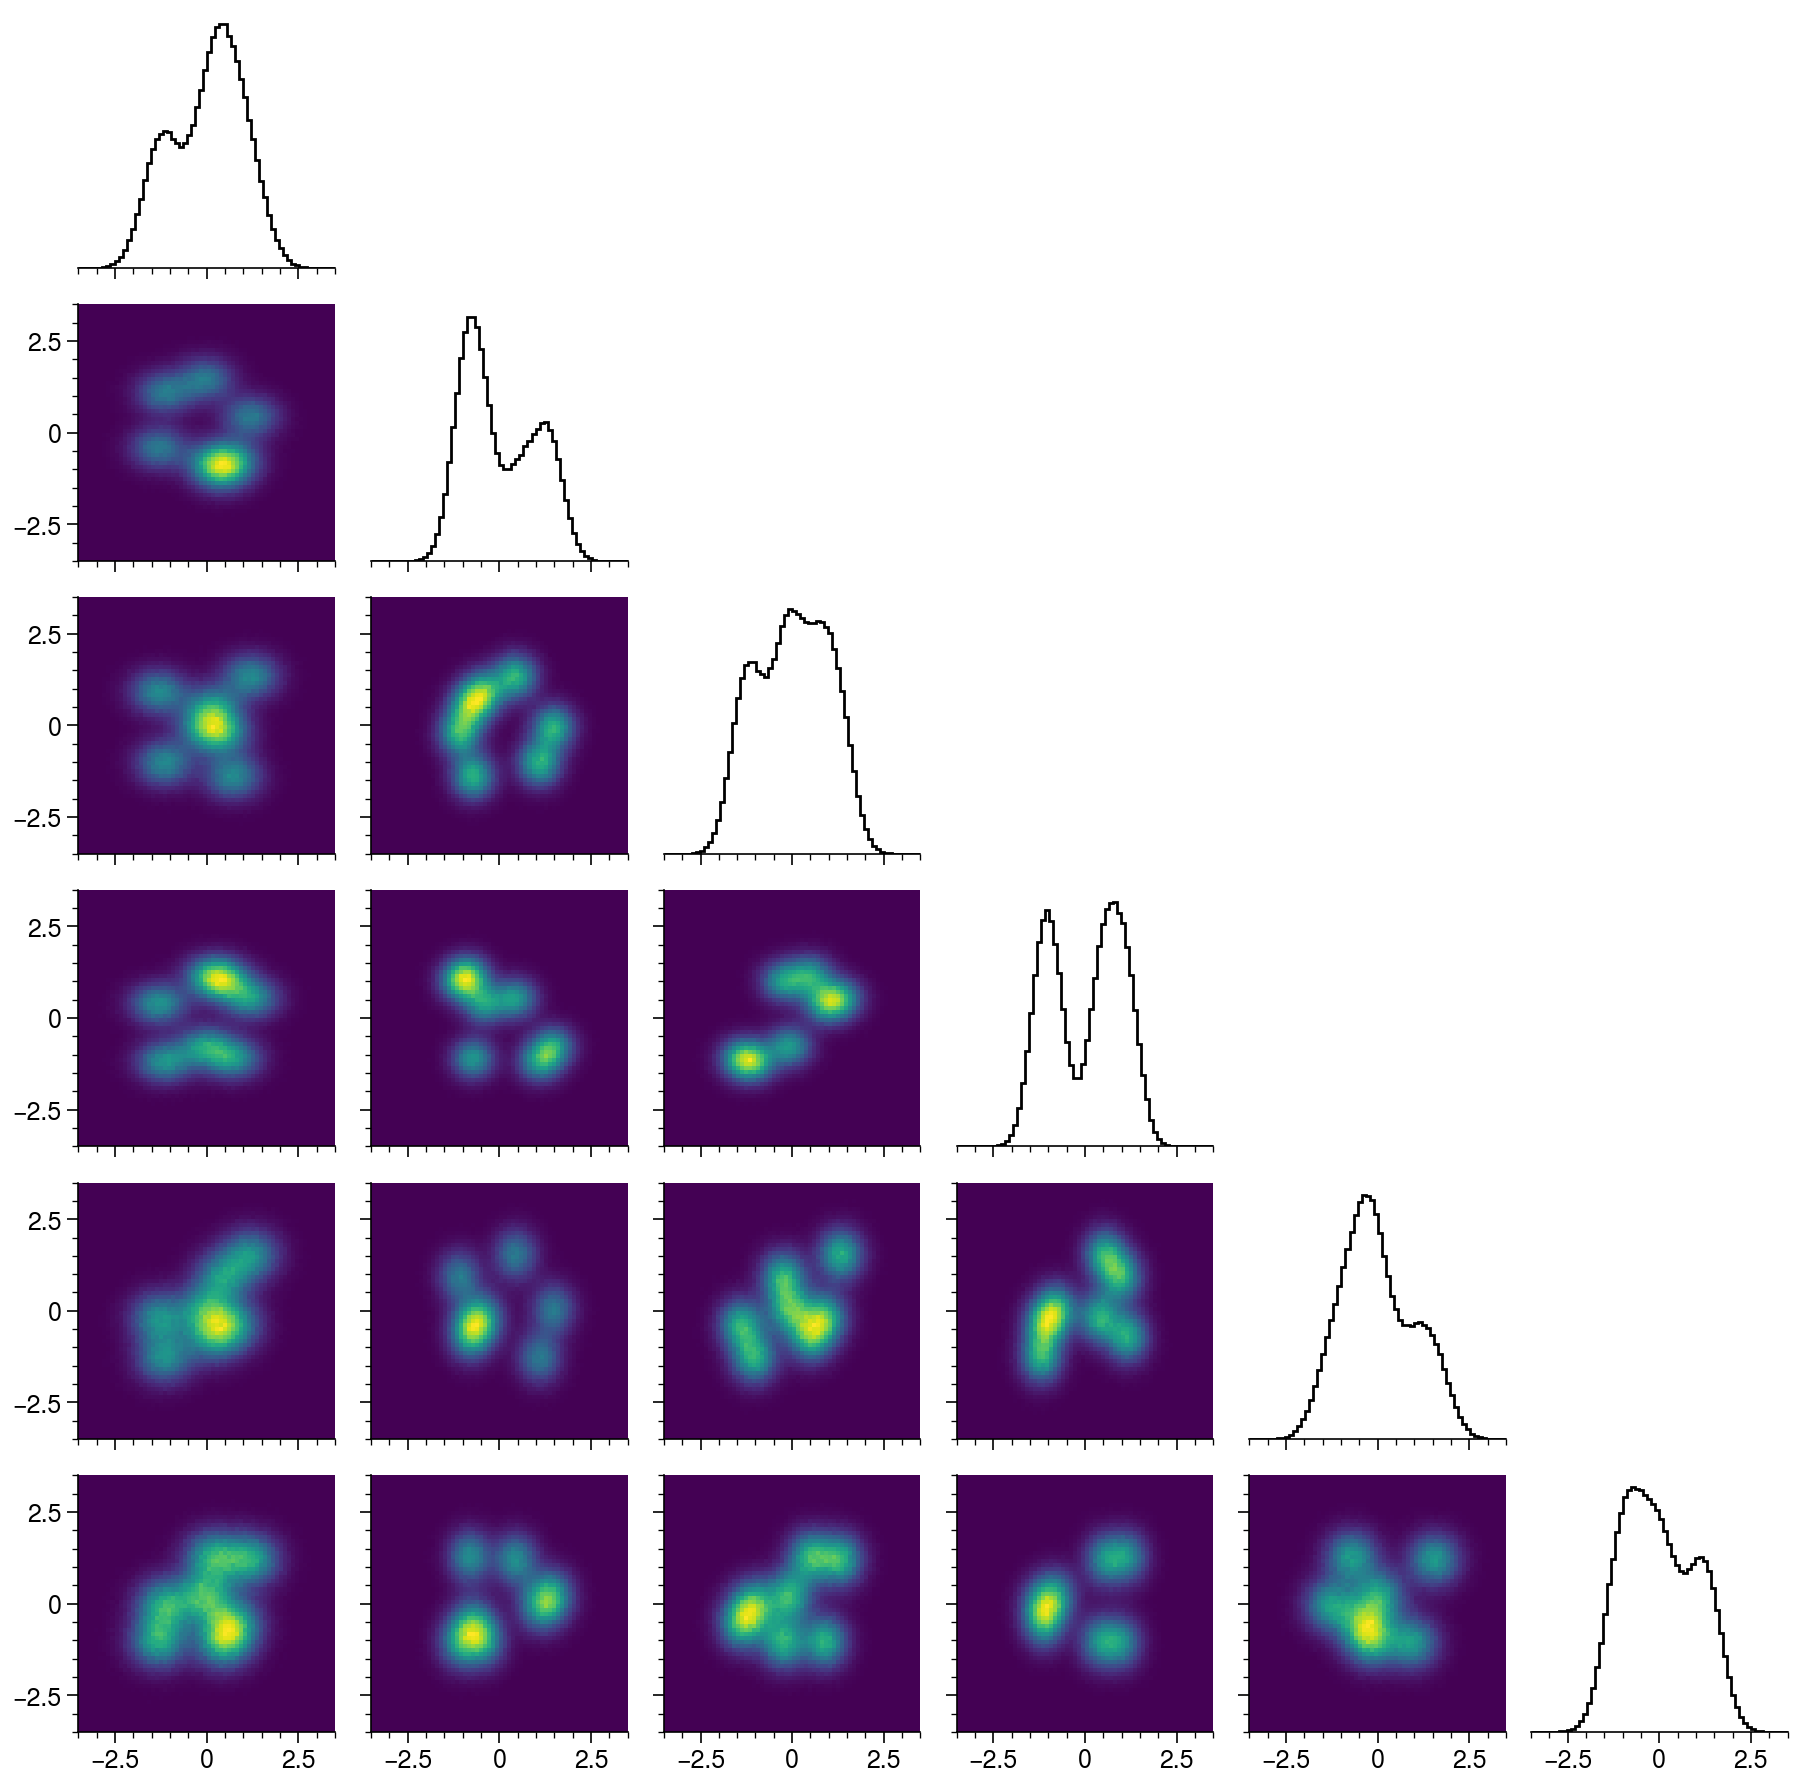

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(X_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
# Settings
nbins = 40
nmeas = ndim
kde = False
kde_bandwidth = 1.0

## Measure 1D marginals
rng = np.random.default_rng(seed)
axis_meas = 0
n_meas = ndim

# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    j = axis_meas
    matrix = np.identity(ndim)
    matrix[i, i] = matrix[j, j] = 0.0
    matrix[i, j] = matrix[j, i] = 1.0
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth=kde_bandwidth
    )
    diagnostics.append([diagnostic])

# Generate data.
projections = ment.sim.forward(X_true, transforms, diagnostics)

## Reconstruction model

In [7]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    projections=projections,
    transforms=transforms,
    diagnostics=diagnostics,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=True,
)

## Training

In [8]:
learning_rate = 1.0
n_epochs = 2
plot_nsamp = 1_000_000
plot_nbins = nbins

In [9]:
def plot_model(model):
    figs = []

    # Plot reconstructed distribution.
    X_pred = model.sample(plot_nsamp)

    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        X_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Plot simulated vs. measured projections.
    projections_true = model.projections
    projections_pred = ment.sim.forward(X_pred, transforms, diagnostics)

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))

    for log in [False, True]:
        fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5 * ncols, 1.25 * nrows))
        for index, transform in enumerate(transforms):
            transform = transforms[index]
            projection = unravel(projections)[index]
            diagnostic = unravel(diagnostics)[index]

            values_pred = diagnostic(transform(X_pred))
            values_meas = projection
            scale = np.max(values_meas)

            ax = axs[index]
            ax.plot(diagnostic.coords, values_meas / scale, color="lightgray")
            ax.plot(diagnostic.coords, values_pred / scale, color="black", marker=".", lw=0, ms=1.0)
            ax.format(ymax=1.25, xlim=(-xmax, xmax))
            if log:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-05, yformatter="log")
        figs.append(fig)

    return figs

non numeric history values being saved


100%|█████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 4102.65it/s]


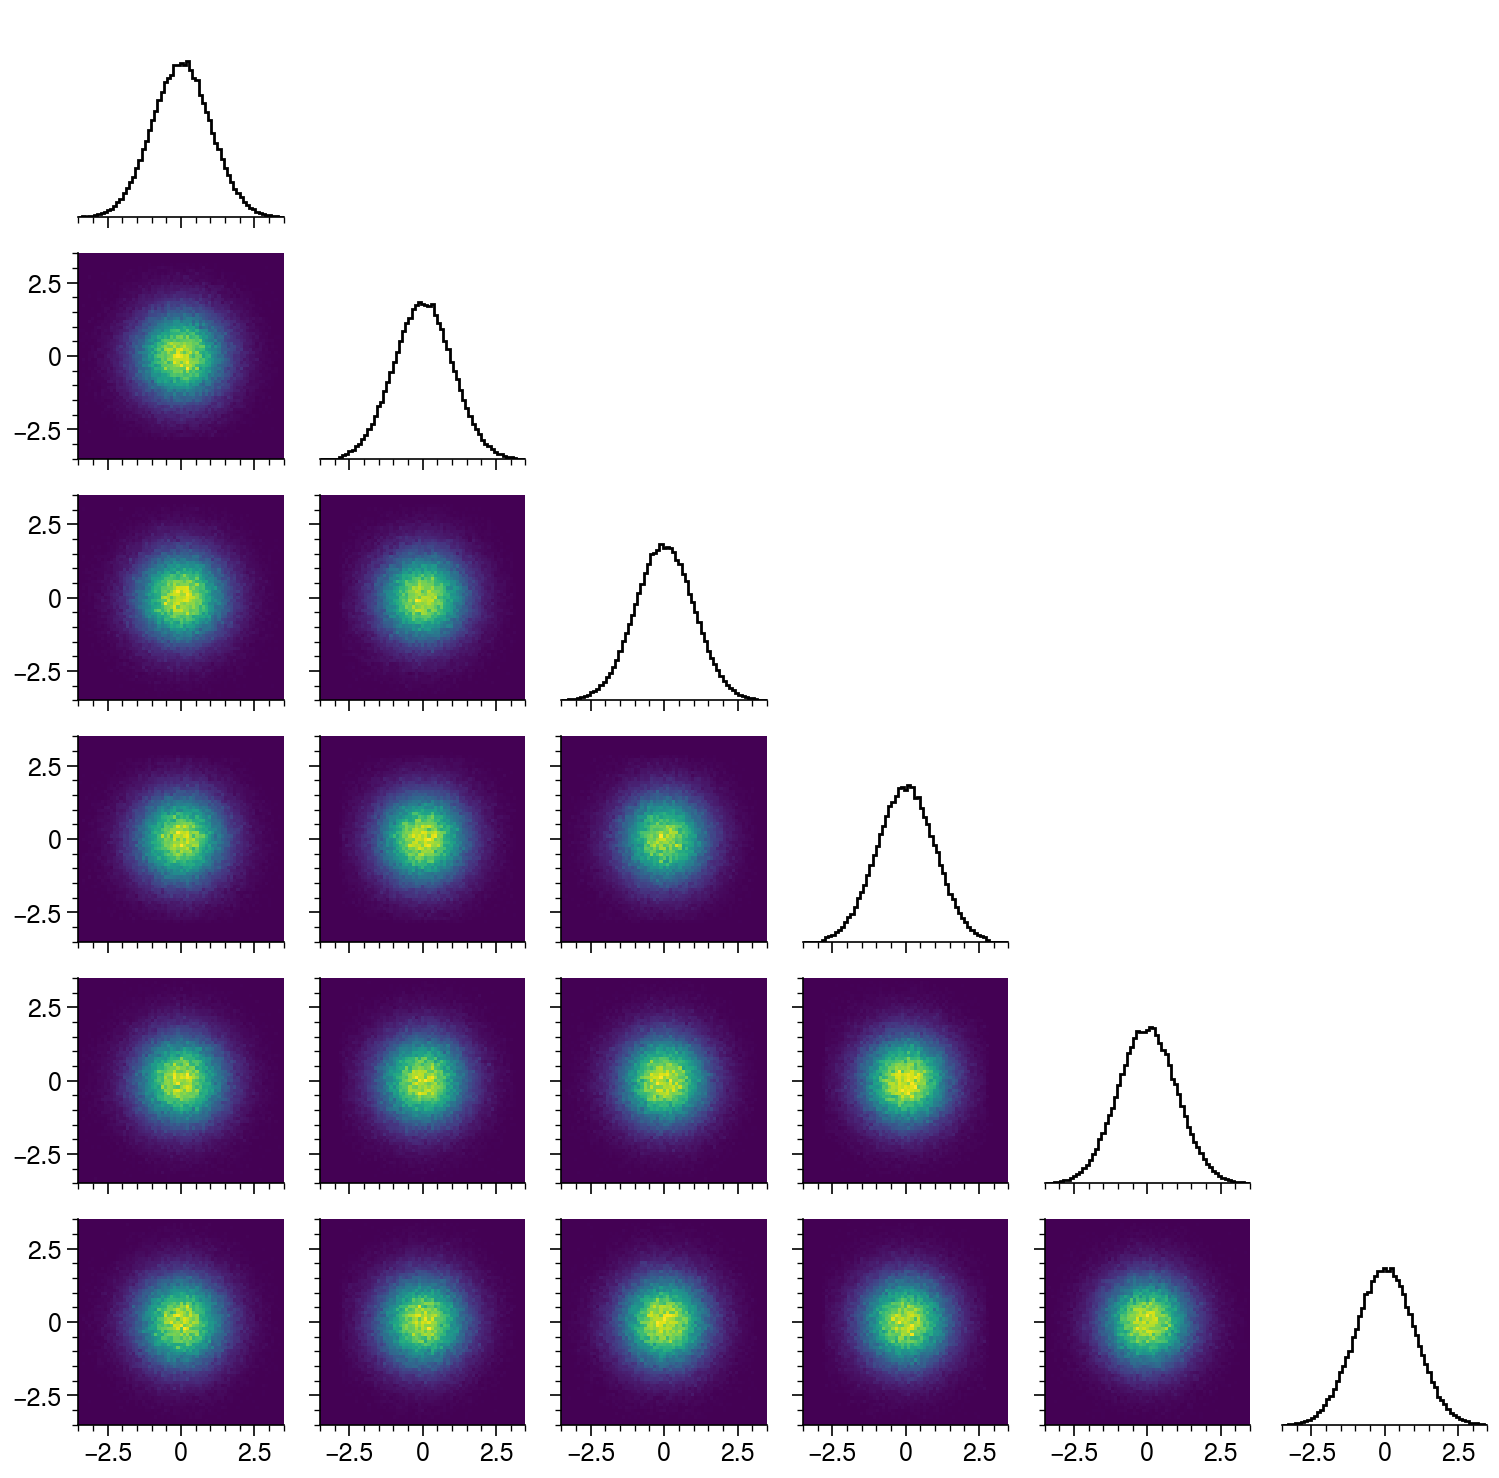

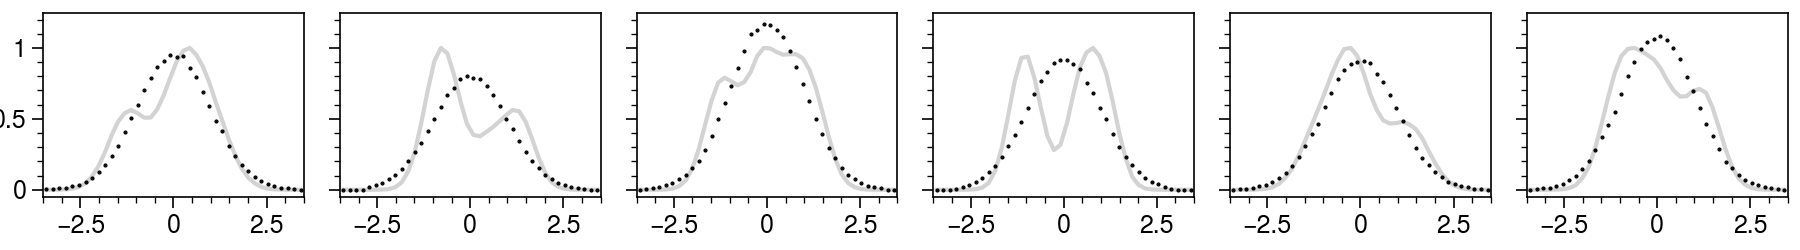

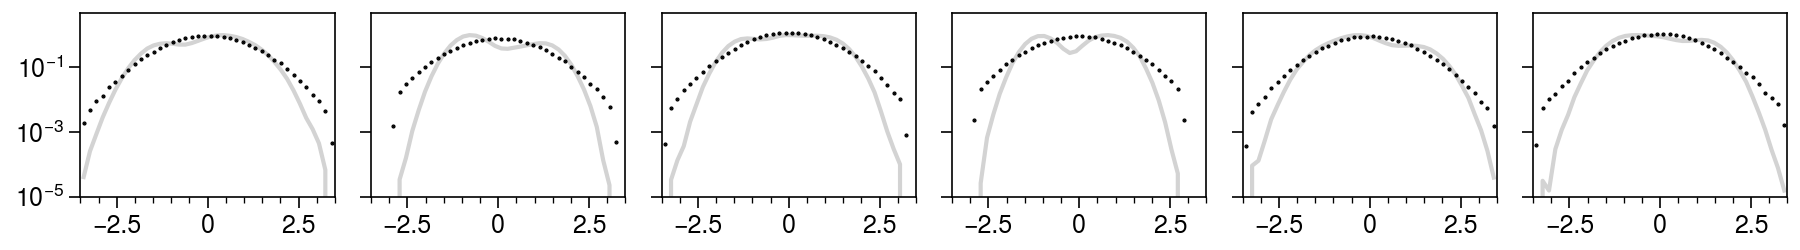

epoch = 1
index=0


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3887.40it/s]


index=1


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3869.60it/s]


index=2


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3855.36it/s]


index=3


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3826.61it/s]


index=4


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3921.82it/s]


index=5


100%|█████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3986.40it/s]


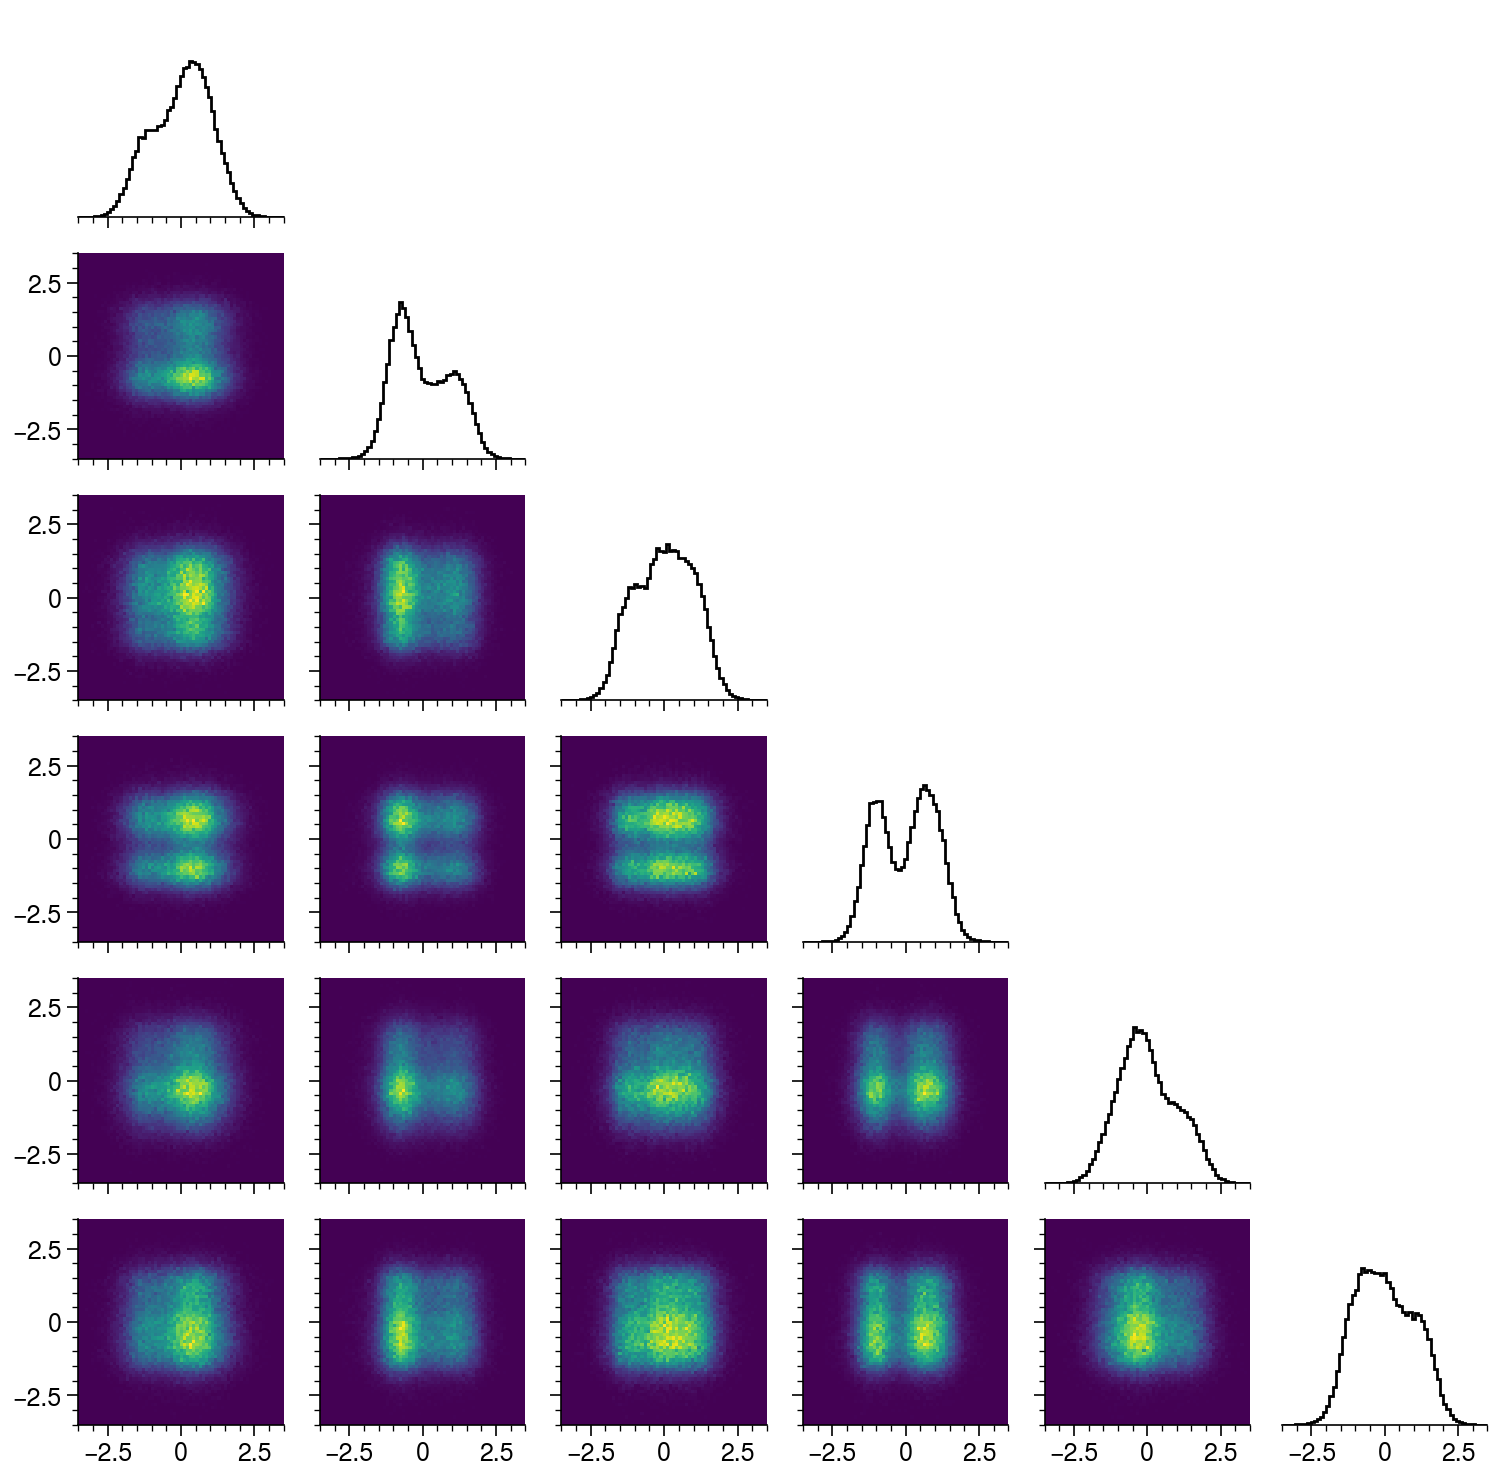

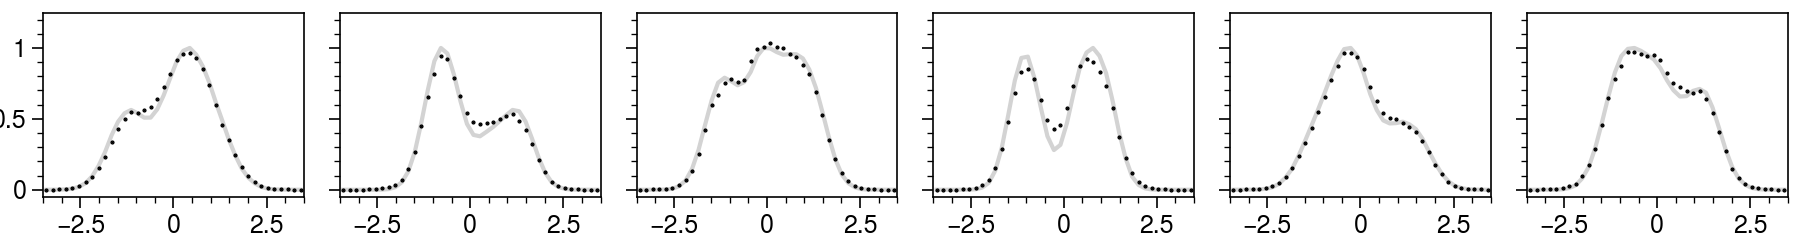

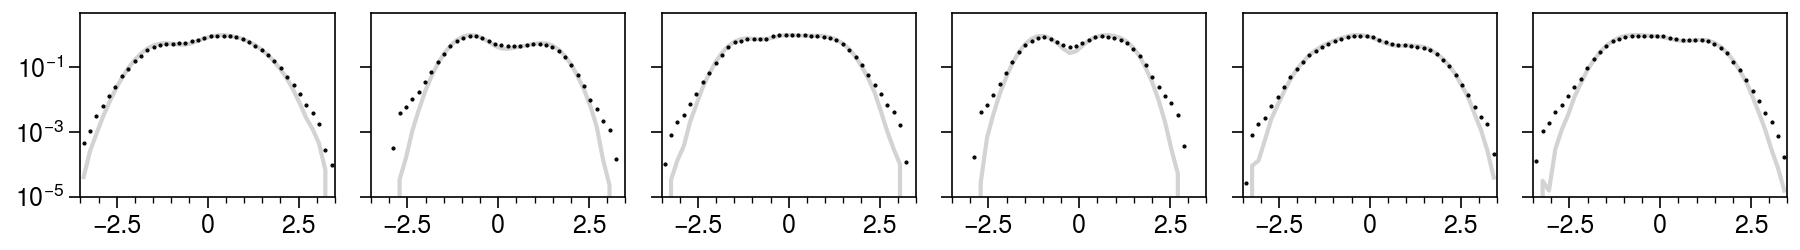

epoch = 2
index=0


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3810.79it/s]


index=1


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3840.07it/s]


index=2


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3937.96it/s]


index=3


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3869.70it/s]


index=4


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3961.18it/s]


index=5


100%|█████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3915.19it/s]


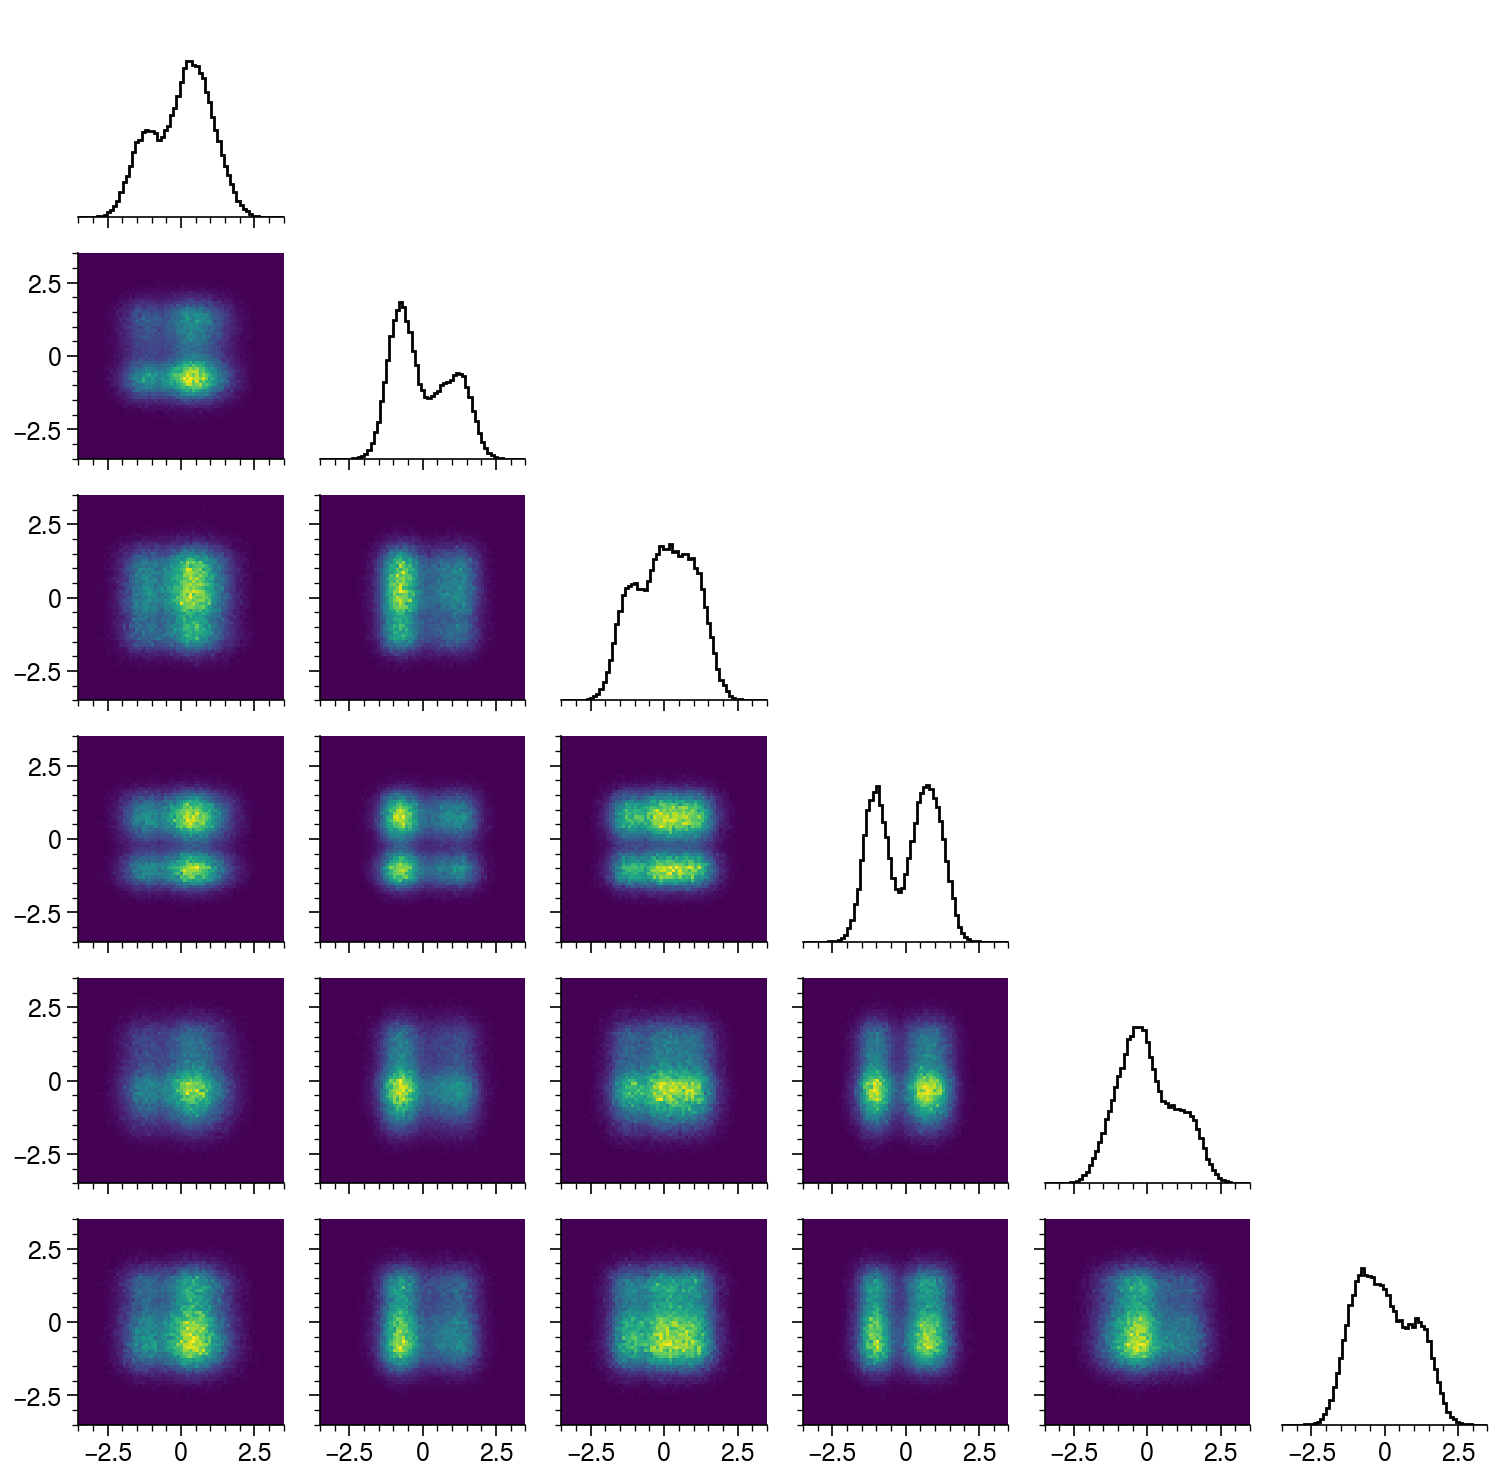

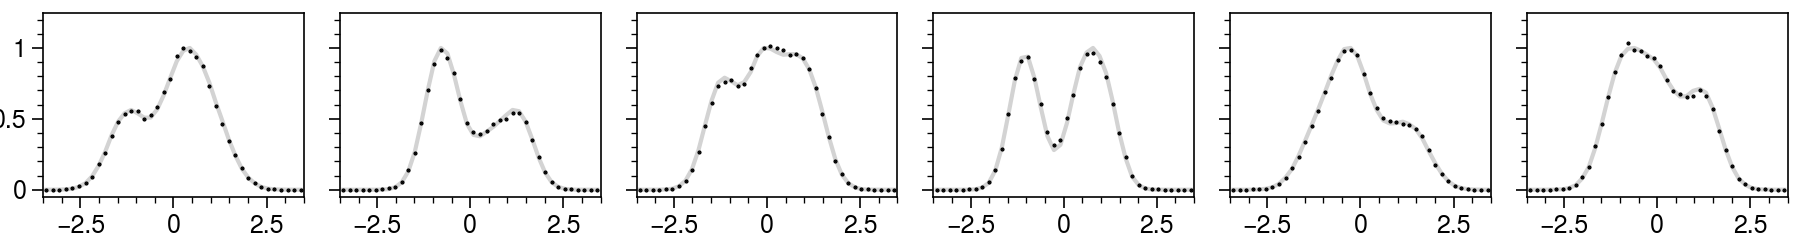

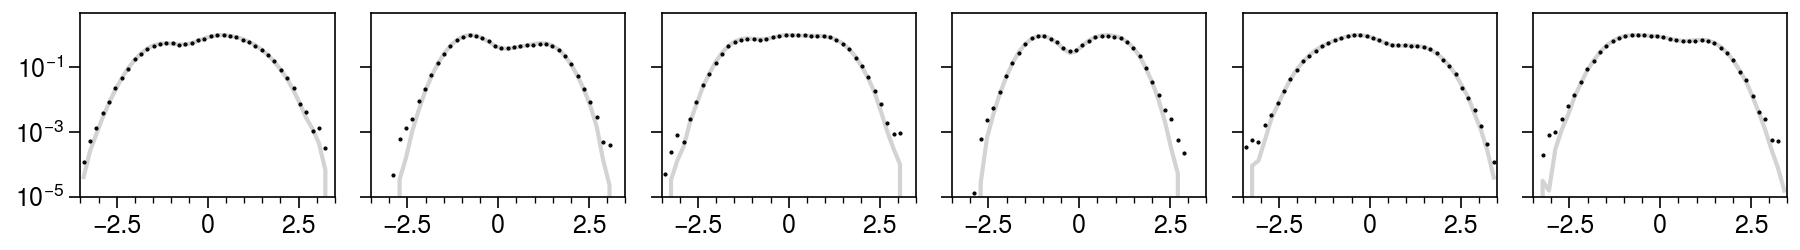

epoch = 3
index=0


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3926.49it/s]


index=1


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3891.09it/s]


index=2


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3862.49it/s]


index=3


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3904.09it/s]


index=4


100%|█████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3859.88it/s]


index=5


100%|█████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3910.72it/s]


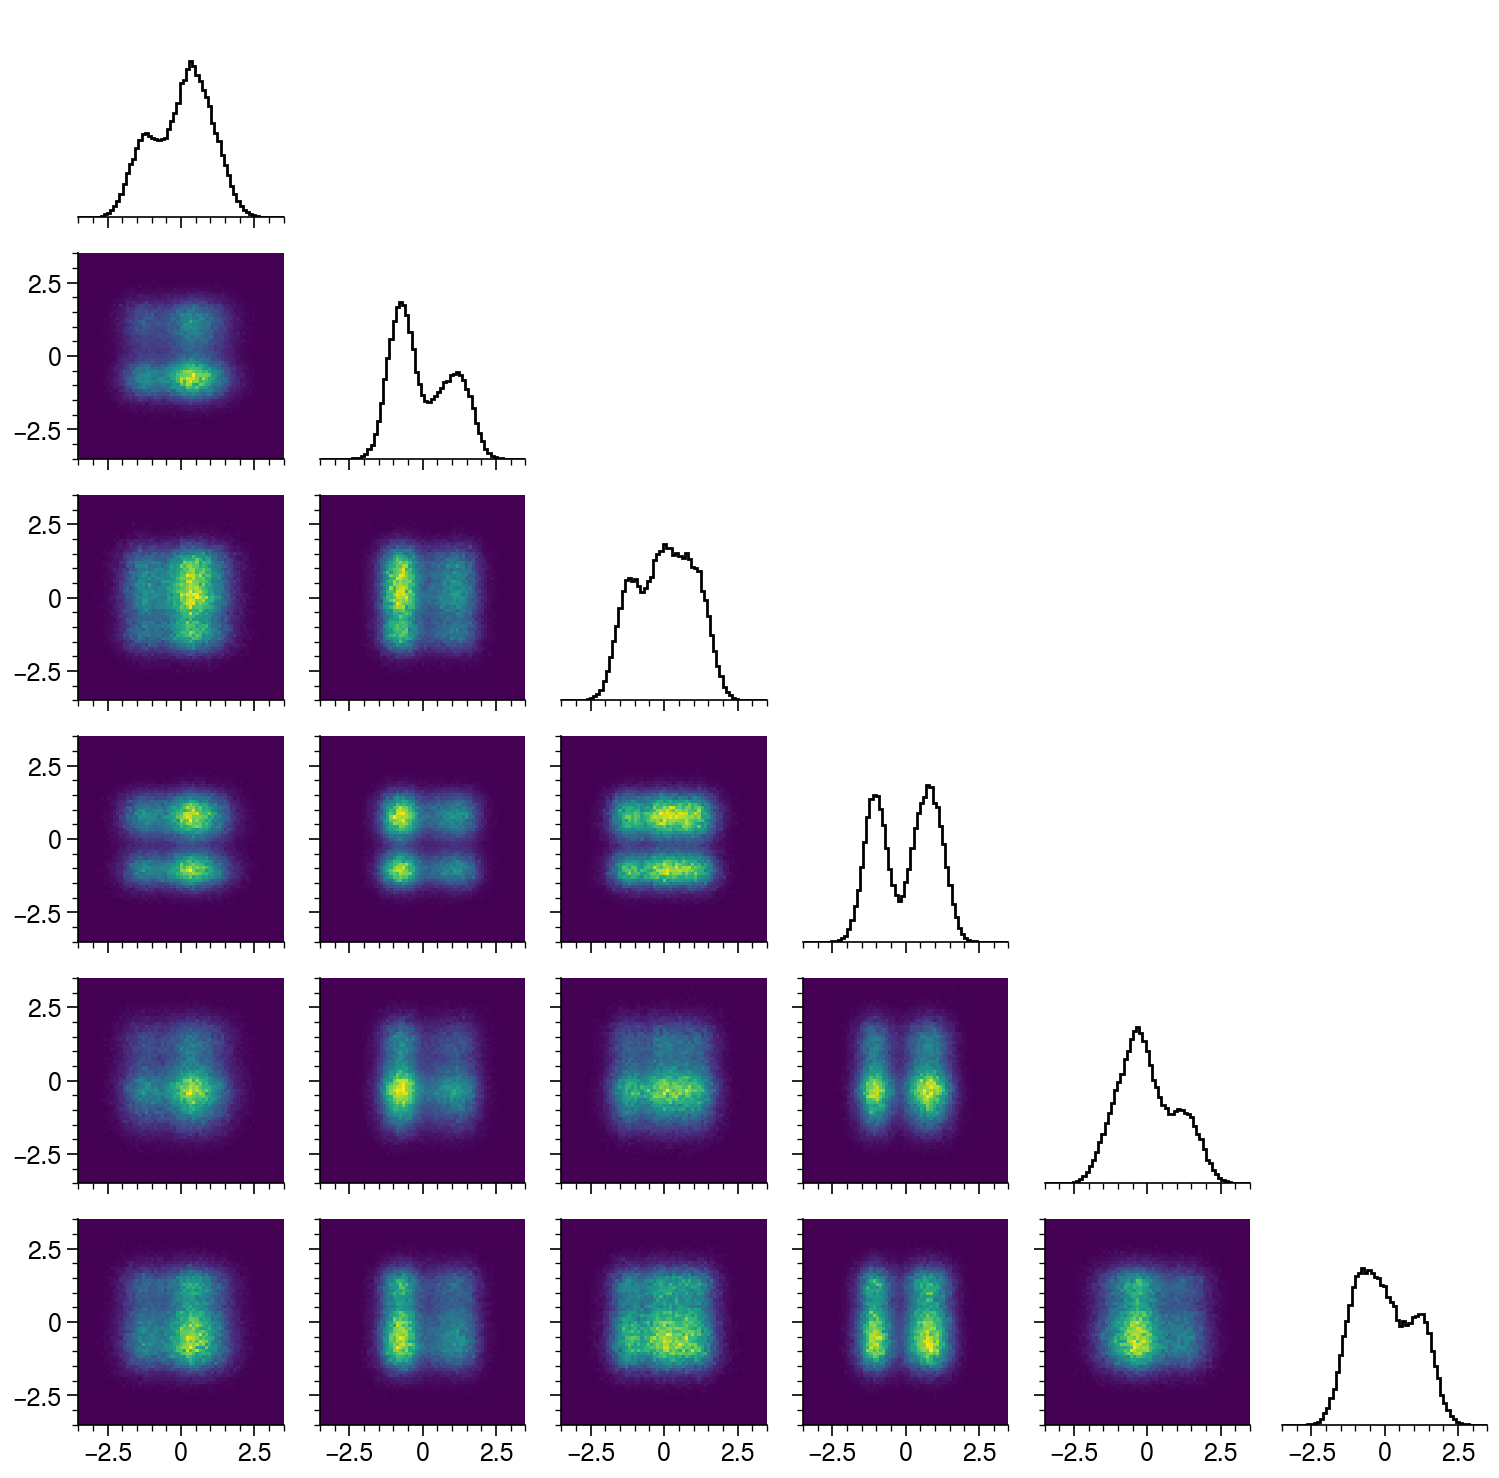

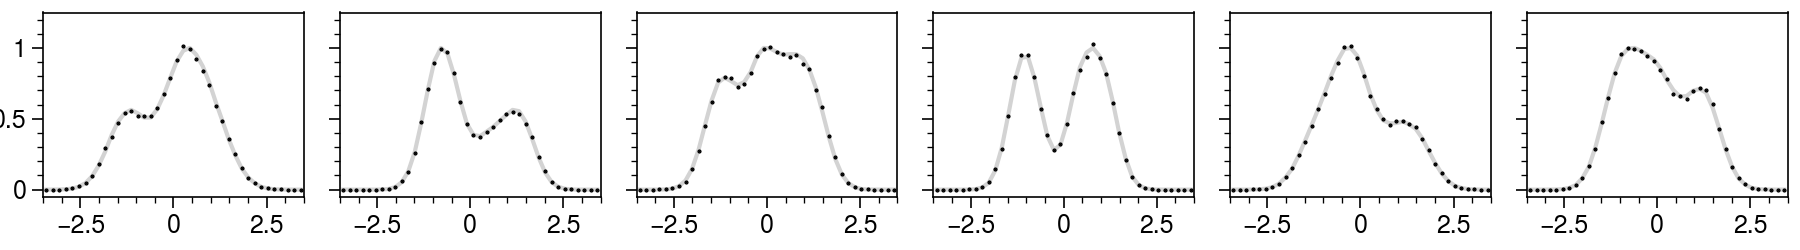

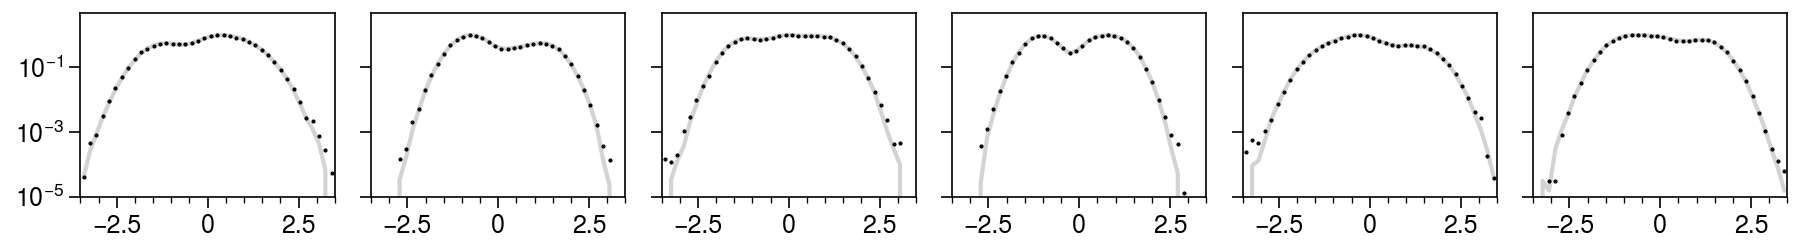

In [10]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)

## Evaluation

In [11]:
X_pred = model.sample(100_000)

100%|█████████████████████████████████████████████████████████████████████████████| 10402/10402 [00:02<00:00, 3850.58it/s]


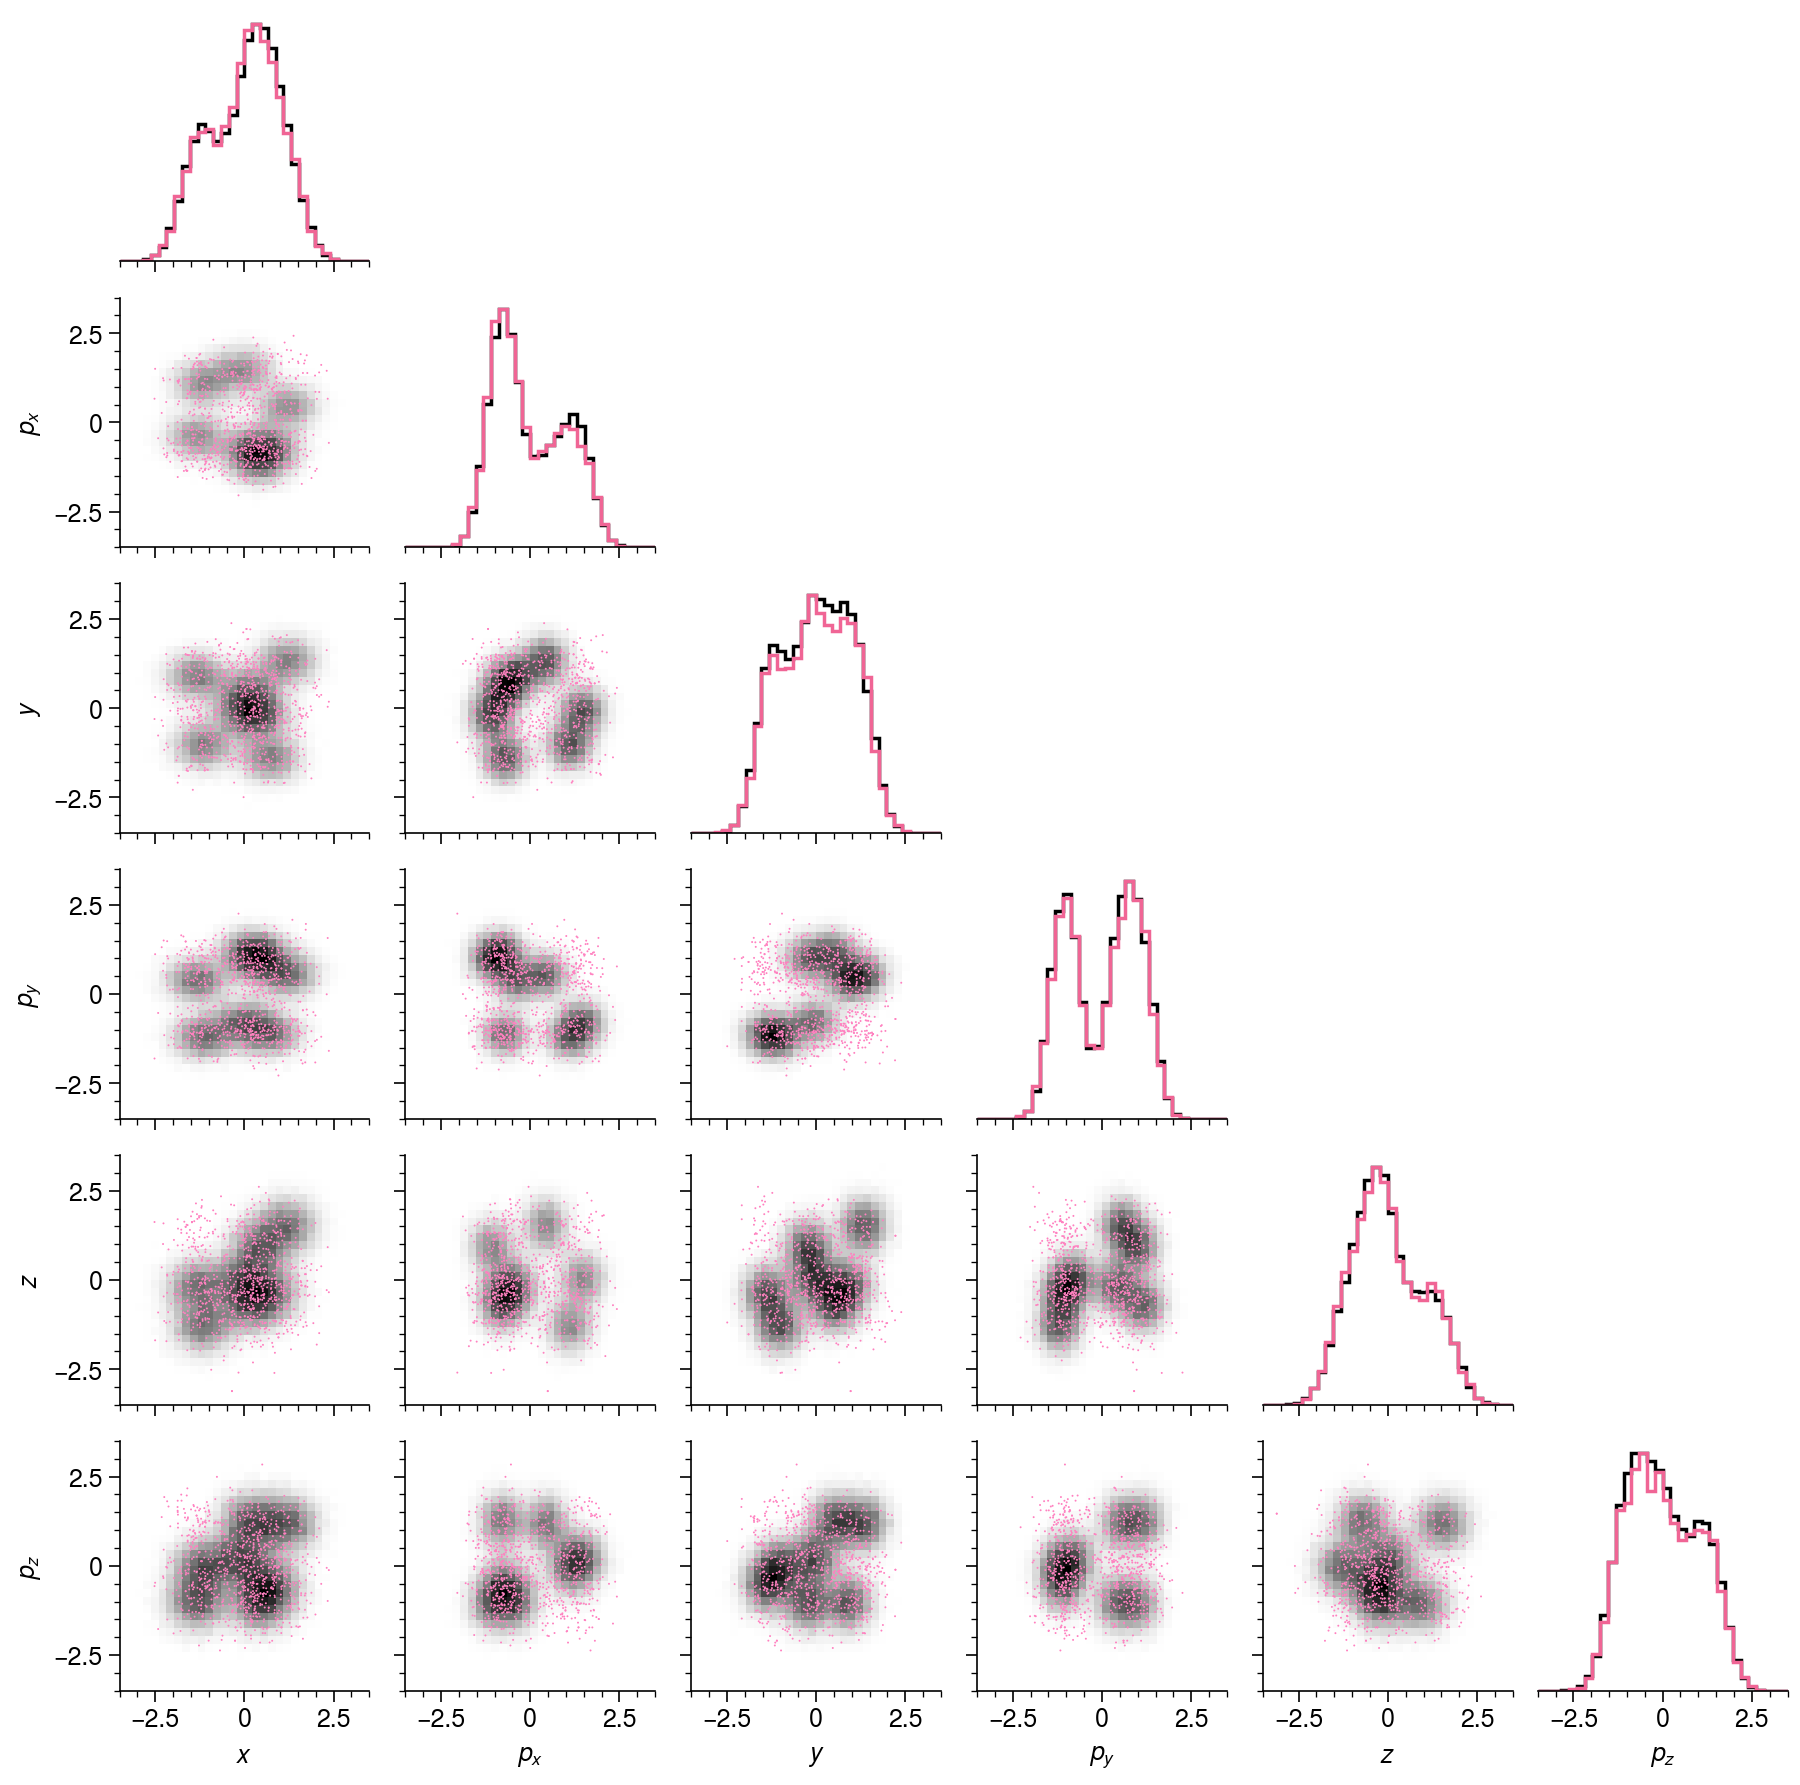

In [12]:
color = "pink"
bins = 32

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(
    X_true[: X_pred.shape[0], :],
    limits=(ndim * [(-xmax, xmax)]),
    bins=bins,
    mask=False,
    cmap="mono",
    diag_kws=dict(lw=1.25, color="black"),
)
grid.plot_points(
    X_pred,
    limits=(ndim * [(-xmax, xmax)]),
    bins=bins,
    diag_kws=dict(lw=1.25, color="pink5"),
    alpha=0.0,
)
grid.plot_points(
    X_pred[:1000, :],
    diag=False,
    kind="scatter",
    c=color,
    s=0.5,
)
grid.set_limits(ndim * [(-xmax, xmax)])
grid.set_labels([r"$x$", r"$p_x$", r"$y$", r"$p_y$", r"$z$", r"$p_z$"])
plt.show()